# Моя реализация алгоритма взвешенного KNN для регрессии

Импортируем необходимые библиотеки для создания класса и для сравнения результатов предсказания с встроенной в sklearn моделью

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_percentage_error

Модель будет поддерживать четыре метрики расчета расстояния между объектами: Евклидову, Чебышева, Манхэттена и косинусное расстояние. Также есть возможность использовать взвешенную вариацию, доступные веса: ранговые и по расстоянию.

In [2]:
class MyKNNReg:
  def __init__(self, k=3, metric = 'euclidean', weight='uniform'):
    self.k = k
    self.train_size = None
    self.metric = metric
    self.weight = weight

  def __str__(self):
    return f'MyKNNReg class: k={self.k}'

  def fit(self, X: pd.DataFrame, y: pd.Series):
    self.X_train = np.array(X)
    self.y_train = np.array(y)
    self.train_size = X.shape

  def predict(self, X):
    X = np.array(X)
    # находим расстояние от каждого объекта тестовой выборки до каждого объекта тренировочной
    if self.metric == 'euclidean':
      distances = np.linalg.norm(X[:, np.newaxis] - self.X_train, axis=2) # разность по последней оси, где и будут наши признаки

    elif self.metric == 'chebyshev':
      distances = np.max(np.abs(X[:, np.newaxis] - self.X_train), axis=2) # разность по последней оси, где и будут наши признаки

    elif self.metric == 'manhattan':
      distances = np.sum(np.abs(X[:, np.newaxis] - self.X_train), axis=2) # разность по последней оси, где и будут наши признаки

    elif self.metric == 'cosine':
      distances = 1 - np.sum(X[:, np.newaxis]*self.X_train, axis=2)/np.sum(X**2, axis=1)[:, np.newaxis]**0.5/np.sum(self.X_train**2, axis=1)**0.5

    nearest_indexes = np.argsort(distances)[:, :self.k] # для каждого тестовой выборки выбираем k ближайших
    nearest = self.y_train[nearest_indexes]

    if self.weight == 'uniform':
      y_pred = np.mean(nearest, axis=1)

    elif self.weight == 'rank':
      ranks = np.ones(nearest_indexes.shape)+np.arange(self.k)

      weights = (1/ranks)/np.sum(1/ranks, axis=1)[:, np.newaxis]
      y_pred = np.sum(nearest*weights, axis=1)

    elif self.weight == 'distance':
      distances_nearest = np.sort(distances, axis=1)[:, :self.k]
      distance_weights = (1/distances_nearest)/np.sum(1/distances_nearest, axis=1)[:, np.newaxis]
      y_pred = np.sum(nearest*distance_weights, axis=1)

    return y_pred

Создадим выборку объектов для регрессии с помощью встроенной функции sklearn:

In [3]:
X, y = make_regression(n_samples=1000, n_features=14, n_informative=10, noise=15, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y)

Обучим модель на тренировочной части выборки, используя разные параметры:

In [24]:
model = MyKNNReg(3, 'euclidean', 'uniform')
model.fit(X_train, y_train)
y_pred_1 = model.predict(X_test)
y_pred_1[:5]

array([-43.72275567, -61.73415548,  -1.22868785, 111.92541968,
       -11.02037515])

In [23]:
model = MyKNNReg(4, 'chebyshev', 'distance')
model.fit(X_train, y_train)
y_pred_2 = model.predict(X_test)
y_pred_2[:5]

array([ 57.42440591,   2.88948434,  75.16249128,  83.15621819,
       -16.06592315])

In [25]:
model = MyKNNReg(5, 'cosine', 'distance')
model.fit(X_train, y_train)
y_pred_3 = model.predict(X_test)
y_pred_3[:5]

array([ 52.80397079, -41.73103585, -17.41281596, 103.26107277,
       -19.81974344])

In [26]:
y_pred = [y_pred_1, y_pred_2, y_pred_3]

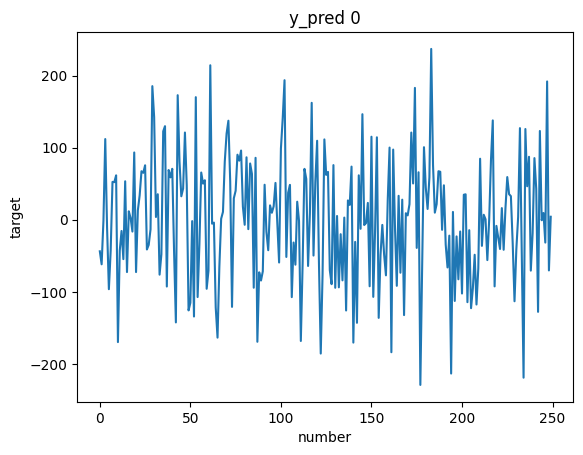

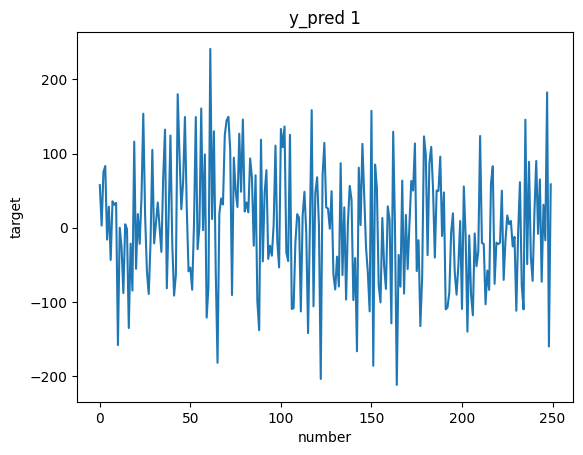

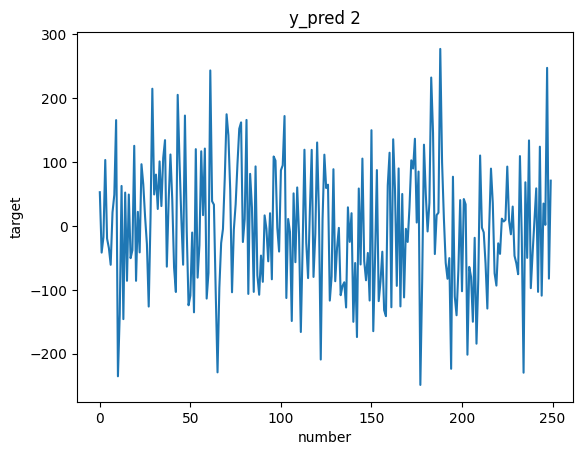

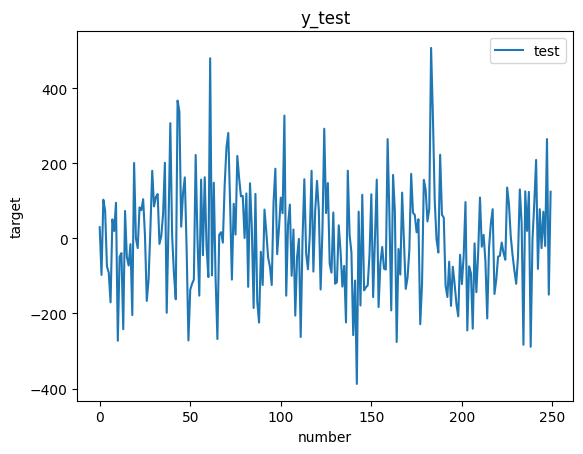

In [27]:
for i in range(len(y_pred)):
  plt.title(f'y_pred {i}')
  plt.xlabel('number')
  plt.ylabel('target')
  plt.plot(y_pred[i], label=f'y_pred {i}')
  plt.show()

plt.title(f'y_test')
plt.xlabel('number')
plt.ylabel('target')
plt.plot(y_test, label='test')
plt.legend()
plt.show()

In [12]:
for i in range(len(y_pred)):
  print(f'y_pred {i} MAPE = ', mean_absolute_percentage_error(y_test, y_pred[i]))

y_pred 0 MAPE =  2.8152534353720604
y_pred 1 MAPE =  3.1625070877282644
y_pred 2 MAPE =  2.9632095241994376


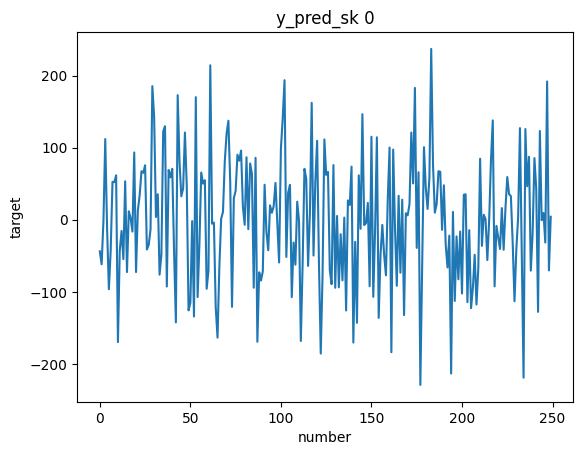

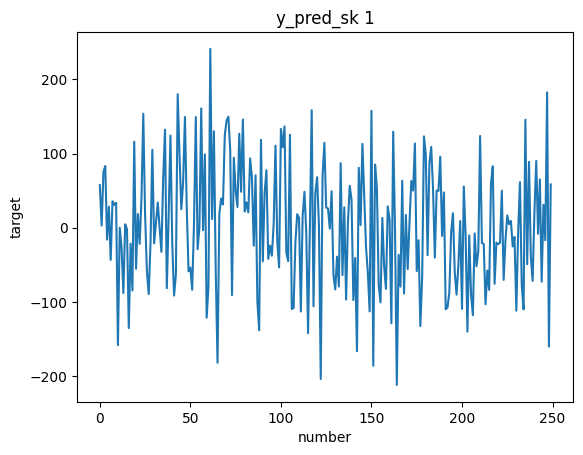

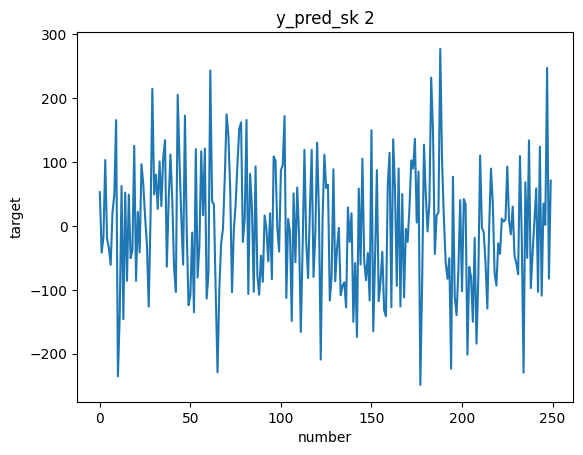

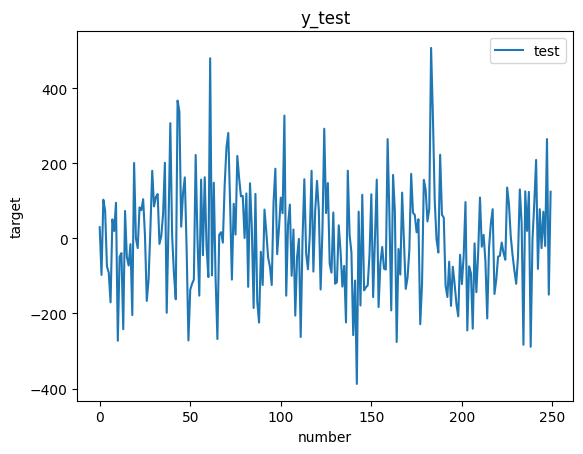

In [18]:
model_sk_1 = KNeighborsRegressor(3, weights = 'uniform', metric = 'euclidean')
model_sk_2 = KNeighborsRegressor(4, weights =  'distance', metric = 'chebyshev')
model_sk_3 = KNeighborsRegressor(5, weights = 'distance', metric = 'cosine')
models = [model_sk_1, model_sk_2, model_sk_3]
y_pred_sk = []
for i in range(3):
  model = models[i]
  model.fit(X_train, y_train)
  y_pred_sk.append(model.predict(X_test))

for i in range(len(y_pred_sk)):
  plt.title(f'y_pred_sk {i}')
  plt.xlabel('number')
  plt.ylabel('target')
  plt.plot(y_pred_sk[i], label=f'y_pred_sk {i}')
  plt.show()

plt.title(f'y_test')
plt.xlabel('number')
plt.ylabel('target')
plt.plot(y_test, label='test')
plt.legend()
plt.show()

In [28]:
for i in range(len(y_pred_sk)):
  print(f'y_pred_sk {i} MAPE = {mean_absolute_percentage_error(y_test, y_pred_sk[i])}, y_pred {i} MAPE = {mean_absolute_percentage_error(y_test, y_pred[i])}')

y_pred_sk 0 MAPE = 2.8152534353720604, y_pred 0 MAPE = 2.8152534353720604
y_pred_sk 1 MAPE = 2.5140490286544743, y_pred 1 MAPE = 2.5140490286544743
y_pred_sk 2 MAPE = 2.9632095241994376, y_pred 2 MAPE = 2.9632095241994376


Как видно из графиков и результатов расчетов метрик, данная реализация дает такой же по точности результат, как и встроенная в sklearn модель, но поддерживает так же взвешивание по рангам, поэтому я считаю этот вариант стандартного алгоритма успешным.